In [9]:
import pickle
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import glob as glob
import scipy
from fractions import Fraction
import sys; sys.path.append("../../..")  # Allows access to all the scripts/modules in the larger directory
from utils import calc_loadings
from collections import defaultdict

### Load consolidated dimreduc dataframe

In [3]:
path = '/home/marcush/Data/TsaoLabData/neural_control_output/degraded_decoding_med_batch/degraded_decoding_med_batch_glom.pickle'
with open(path, 'rb') as f:
    dat = pickle.load(f) 

df_dimreduc = pd.DataFrame(dat)

In [4]:
df_dimreduc.columns

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'predictions', 'loss',
       'decoding_object', 'Xtrain', 'Xtest', 'Ytrain', 'Ytest', 'decoder',
       'decoder_args', 'thresholds', 'data_file', 'loader', 'loader_args',
       'task_args', 'data_path', 'results_file'],
      dtype='object')

### Load CCA model

In [4]:
ccamodel_dir = df_dimreduc['data_path'][0] + "/preloaded"

# ASSUME ONLY ONE MODEL HAS BEEN COMPUTED FOR NOW
ccamodel_path = glob.glob(ccamodel_dir+"/CCA_*.pickle")[0]

with open(ccamodel_path, 'rb') as file:
    ccamodel = pickle.load(file)

### Extract useful params 

In [5]:
dimensions = np.unique(df_dimreduc['dim'])
n_folds = np.unique(df_dimreduc['fold_idx'])
regions = np.unique(df_dimreduc['loader_args'].apply(lambda x: x.get('region')))
dimreduc_methods = np.unique(df_dimreduc['dimreduc_method'])

##### Useful for plotting later

In [6]:
def simplify_pi_fraction(x):
    frac = Fraction(x / np.pi).limit_denominator()
    if frac.numerator == 0:
        return "0"
    elif frac.denominator == 1:
        return r"$" + str(frac.numerator) + r"\pi$"
    else:
        return r"$\frac{" + str(frac.numerator) + r"\pi}{" + str(frac.denominator) + r"}$"


### Get within area subspace angle differences [for fixed dimension]

In [10]:
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)
subspace_angles = recursive_defaultdict()

#ML_cca_proj = ccamodel.x_rotations_
#AM_cca_proj = ccamodel.y_rotations_

for reg in regions:
    if reg == 'ML':
        cca_proj = ccamodel.x_rotations_
    else:
        cca_proj = ccamodel.y_rotations_


    for dim in dimensions:
        FFCvFBC_n_fold_sub_angles = np.zeros((len(n_folds), dim))
        FFCvCCA_n_fold_sub_angles = np.zeros((len(n_folds), dim))
        FBCvCCA_n_fold_sub_angles = np.zeros((len(n_folds), dim))

        for n_fold in n_folds:

            FFC_coef = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == reg)  & 
                                            (df_dimreduc['dim'] == dim) & (df_dimreduc['fold_idx'] == n_fold) &
                                            (df_dimreduc['dimreduc_method'] == 'PCA')]['coef'].iloc[0]

            FBC_coef = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == reg)  & 
                                (df_dimreduc['dim'] == dim) & (df_dimreduc['fold_idx'] == n_fold) &
                                (df_dimreduc['dimreduc_method'] == 'LQGCA')]['coef'].iloc[0]
            
            #print(np.shape(FFC_coef), np.shape(FBC_coef), type(subspace_angles))
            FFCvFBC = scipy.linalg.subspace_angles(FFC_coef, FBC_coef)
            FFCvCCA = scipy.linalg.subspace_angles(FFC_coef, cca_proj[:, 0:dim])
            FBCvCCA = scipy.linalg.subspace_angles(FBC_coef, cca_proj[:, 0:dim])


            FFCvFBC_n_fold_sub_angles[n_fold,:] = FFCvFBC
            FFCvCCA_n_fold_sub_angles[n_fold,:] = FFCvCCA
            FBCvCCA_n_fold_sub_angles[n_fold,:] = FBCvCCA

            
        subspace_angles[reg]['FFCvFBC'][dim] = np.mean(FFCvFBC_n_fold_sub_angles, 0) 
        subspace_angles[reg]['FFCvCCA'][dim] = np.mean(FFCvCCA_n_fold_sub_angles, 0) 
        subspace_angles[reg]['FBCvCCA'][dim] = np.mean(FBCvCCA_n_fold_sub_angles, 0) 


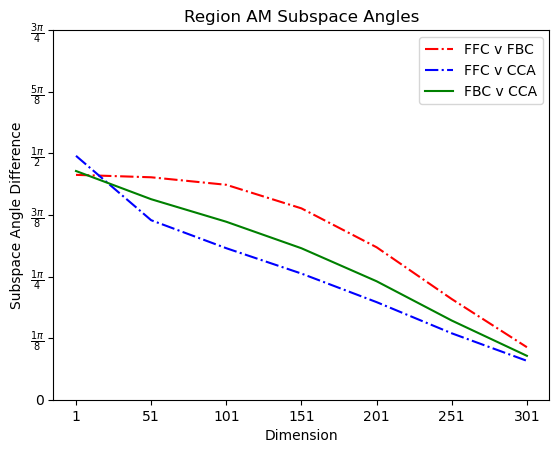

In [17]:
# Just plotting the means per comparison, but could plot min/median/max
region = 'AM'

AM_comps = np.zeros((3, len(dimensions)))
for idx, dim in enumerate(dimensions):
    AM_comps[0, idx] = np.mean(subspace_angles[region]['FFCvFBC'][dim])
    AM_comps[1, idx] = np.mean(subspace_angles[region]['FFCvCCA'][dim])
    AM_comps[2, idx] = np.mean(subspace_angles[region]['FBCvCCA'][dim])


plt.plot(dimensions, AM_comps[0, :], '-.', label="FFC v FBC", color='red')
plt.plot(dimensions, AM_comps[1, :], '-.', label="FFC v CCA", color='blue')
plt.plot(dimensions, AM_comps[2, :],  label="FBC v CCA", color='green')

plt.legend()
plt.title(f'Region {region} Subspace Angles')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Subspace Angle Difference')

# Manually set the y-axis ticks and labels
yticks = np.arange(0, 2 * np.pi + np.pi/8, np.pi/8)
#ytick_labels = ['0'] + [r'${}\pi/8$'.format(i) for i in range(1, 16)] + [r'$2\pi$']
ytick_labels = [simplify_pi_fraction(y) for y in yticks]
plt.yticks(yticks, ytick_labels)
plt.ylim([0, 3*np.pi/4])
plt.show()

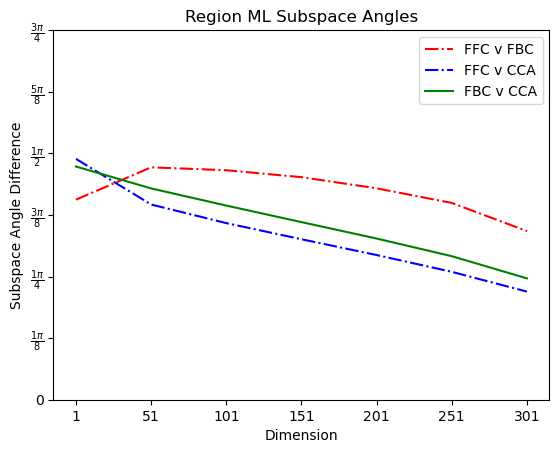

In [16]:
# Just plotting the means per comparison, but could plot min/median/max
region = 'ML'

AM_comps = np.zeros((3, len(dimensions)))
for idx, dim in enumerate(dimensions):
    AM_comps[0, idx] = np.mean(subspace_angles[region]['FFCvFBC'][dim])
    AM_comps[1, idx] = np.mean(subspace_angles[region]['FFCvCCA'][dim])
    AM_comps[2, idx] = np.mean(subspace_angles[region]['FBCvCCA'][dim])


plt.plot(dimensions, AM_comps[0, :], '-.', label="FFC v FBC", color='red')
plt.plot(dimensions, AM_comps[1, :], '-.', label="FFC v CCA", color='blue')
plt.plot(dimensions, AM_comps[2, :],  label="FBC v CCA", color='green')

plt.legend()
plt.title(f'Region {region} Subspace Angles')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Subspace Angle Difference')

# Manually set the y-axis ticks and labels
yticks = np.arange(0, 2 * np.pi + np.pi/8, np.pi/8)
#ytick_labels = ['0'] + [r'${}\pi/8$'.format(i) for i in range(1, 16)] + [r'$2\pi$']
ytick_labels = [simplify_pi_fraction(y) for y in yticks]
plt.yticks(yticks, ytick_labels)
plt.ylim([0, 3*np.pi/4])
plt.show()

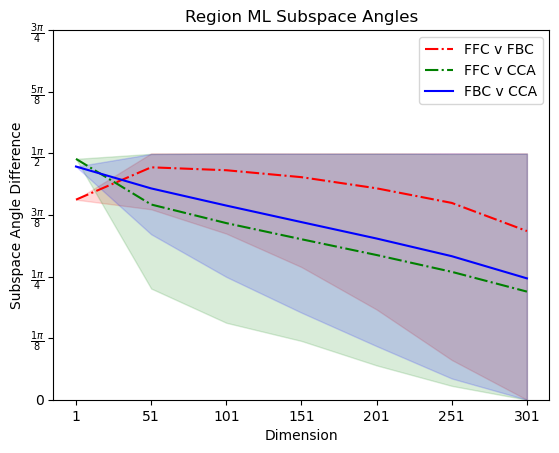

In [19]:
region = 'ML'
AM_comps = np.zeros((3, len(dimensions)))
for idx, dim in enumerate(dimensions):
    AM_comps[0, idx] = np.mean(subspace_angles[region]['FFCvFBC'][dim])
    AM_comps[1, idx] = np.mean(subspace_angles[region]['FFCvCCA'][dim])
    AM_comps[2, idx] = np.mean(subspace_angles[region]['FBCvCCA'][dim])

# Plotting the mean lines
plt.plot(dimensions, AM_comps[0, :], '-.', label="FFC v FBC", color='red')
plt.plot(dimensions, AM_comps[1, :], '-.', label="FFC v CCA", color='green')
plt.plot(dimensions, AM_comps[2, :], label="FBC v CCA", color='blue')

# Adding shaded areas
alpha_value = 0.15  # Adjust the transparency here

for i, comparison in enumerate(['FFCvFBC', 'FFCvCCA', 'FBCvCCA']):
    lower_band = [np.min(subspace_angles[region][comparison][dim]) for dim in dimensions]
    upper_band = [np.max(subspace_angles[region][comparison][dim]) for dim in dimensions]
    plt.fill_between(dimensions, lower_band, upper_band, alpha=alpha_value, color=plt.gca().lines[i].get_color())

plt.legend()
plt.title(f'Region {region} Subspace Angles')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Subspace Angle Difference')

# Custom y-axis ticks and labels - assuming you have the `simplify_pi_fraction` function
yticks = np.arange(0, 2 * np.pi + np.pi/8, np.pi/8)
ytick_labels = [simplify_pi_fraction(y) for y in yticks]  # Define your own function to simplify the fractions
plt.yticks(yticks, ytick_labels)
plt.ylim([0, 3*np.pi/4])

plt.show()


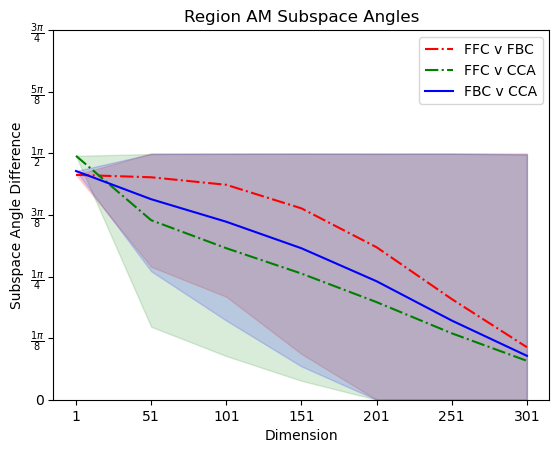

In [20]:
region = 'AM'
AM_comps = np.zeros((3, len(dimensions)))
for idx, dim in enumerate(dimensions):
    AM_comps[0, idx] = np.mean(subspace_angles[region]['FFCvFBC'][dim])
    AM_comps[1, idx] = np.mean(subspace_angles[region]['FFCvCCA'][dim])
    AM_comps[2, idx] = np.mean(subspace_angles[region]['FBCvCCA'][dim])

# Plotting the mean lines
plt.plot(dimensions, AM_comps[0, :], '-.', label="FFC v FBC", color='red')
plt.plot(dimensions, AM_comps[1, :], '-.', label="FFC v CCA", color='green')
plt.plot(dimensions, AM_comps[2, :], label="FBC v CCA", color='blue')

# Adding shaded areas
alpha_value = 0.15  # Adjust the transparency here

for i, comparison in enumerate(['FFCvFBC', 'FFCvCCA', 'FBCvCCA']):
    lower_band = [np.min(subspace_angles[region][comparison][dim]) for dim in dimensions]
    upper_band = [np.max(subspace_angles[region][comparison][dim]) for dim in dimensions]
    plt.fill_between(dimensions, lower_band, upper_band, alpha=alpha_value, color=plt.gca().lines[i].get_color())

plt.legend()
plt.title(f'Region {region} Subspace Angles')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Subspace Angle Difference')

# Custom y-axis ticks and labels - assuming you have the `simplify_pi_fraction` function
yticks = np.arange(0, 2 * np.pi + np.pi/8, np.pi/8)
ytick_labels = [simplify_pi_fraction(y) for y in yticks]  # Define your own function to simplify the fractions
plt.yticks(yticks, ytick_labels)
plt.ylim([0, 3*np.pi/4])

plt.show()
